In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


This notebook contains code to reproduce the following from Mitra, et al.:

**Main Figures:** 
* Figure 3A: Overall mutation burden cases vs. ctrls
* Figure 3B: Size in cases vs. controls
* Figure 3C: mutation burden by category
* Figure 3D: Size diff by category

**Supplementary Figures:** 
* Supplementary Figure 10: OR as function of afreq/het and by male/female
* Supplementary Figure 11: QQ plots for TDT/assoc/fisher
* Supplementary Figure 12: power analysis

In [2]:
# Input per-locus info

#LOCFILE = "/storage/ileena/ssc-gangstr-denovos/denovos_GW_priors_Jan20/combined/SSC_allphases_011720_denovos_GW_priors_Jan20.locus_stats.tab" # old

# Newer locfile with outlier families removed
LOCFILE = "/storage/mgymrek/ssc-denovos/denovos_GW_priors_Jan20/SSC_allphases_011720_denovos_GW_priors_Aug20.locus_stats_rmoutlierfams.tab"

# when done running to remove outlier families

# Input mutation results
MUTFILE = "/storage/ileena/ssc-gangstr-denovos/denovos_GW_priors_Jan20/combined/SSC_allphases_011720_denovos_GW_priors_Jan20.final_qc_mutations.tab"
NAIVEMUTFILE = "/storage/ileena/ssc-gangstr-denovos/denovos_naive_Jan20/SSC_allphases_011720_denovos_naive_Jan20.final_qc_mutations.tab"

# Make editable in Illustrator
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats
import statsmodels.api as sm

# Color keys
colors = ['gray','red','gold','blue','green','purple','brown','salmon','magenta','cyan','darkblue']

# Other data paths
ANNOTFILE = "/storage/mgymrek/ssc-denovos/annotations/hg38_gangstr_MasterAnnotation-rmdup.bed"
AFREQFILE = "/storage/mgymrek/ssc-denovos/allele-freqs-revision/SSC_merged_allele_counts.tab"
HETFILE = "/storage/mgymrek/ssc-denovos/allele-freqs-revision/SSC_merged_het.tab"
AGEFILE = "/storage/ileena/denovos4/metadata/ssc_4phases_ages.csv"
SFARIFILE = "/storage/mgymrek/ssc-denovos/annotations/SFARI-Gene_genes_08-29-2019release_09-11-2019export.csv"
JACKGENES = "/storage/mgymrek/ssc-denovos/annotations/jack_102genes.txt"
CONSTRAINTFILE="/storage/mgymrek/ssc-denovos/mutea/MUTEA_Constraint_hg38_GangSTR.bed"

# Output path info
OUTDIR = "pdfs/"

In [3]:
# Load expansions
ndata = pd.read_csv(NAIVEMUTFILE, sep="\t")
ndata = ndata[(ndata["posterior"]==-1) & (ndata["mutsize"]>=5)] # moderately big expansion events

# Filter ones that occur too many times
expcounts = ndata.groupby(["chrom","pos"], as_index=False).agg({"child": len})
ndata = pd.merge(ndata, expcounts[expcounts["child"]<=3][["chrom","pos"]], on=["chrom","pos"])

# Load main mutations data
alldata = pd.read_csv(MUTFILE, sep="\t")
usefams = set(alldata["family"])

# Concatenate expansions
ndata = ndata[ndata.family.isin(usefams)]
alldata = pd.concat([alldata, ndata])

# Load sfari genes
sfari_genes = set(pd.read_csv(SFARIFILE)["gene-symbol"])
jack_genes = set([item.strip() for item in open(JACKGENES, "r").readlines()])

# Manually remove problematic families. TODO add this instead to the QC script
# 14151 proband had 130 mutations
# other families have <20 in both proband and sibling
rmfams = [14151, 12434, 12281, 13673, 13351, 13355, 13143]
alldata = alldata[~alldata.family.isin(rmfams)]

# Load annotation info
annot = pd.read_csv(ANNOTFILE, sep="\t")

# Set up fields
def GetChrom(x):
    if "chr" in str(x): return int(x[3:])
    else: return int(x)
alldata["chrom"] = alldata["chrom"].apply(GetChrom)
annot = annot[annot["chrom"].apply(lambda x: x not in ["X","chrX","Y","chrY"])]
annot["chrom"] = annot["chrom"].apply(GetChrom)
annot["pos"] = annot["start"]

# Merge
adata = pd.merge(alldata, annot, on=["chrom","pos"])

# Get age info
ages = pd.read_csv(AGEFILE)
ages["family"] = ages["fam_id"]
ages["child"] = ages["sample_id"]
ages["phenotype"] = ages["ssc_id"].apply(lambda x: [1,2]["p1" in x])
ages = ages[~np.isnan(ages["father_age_birth"])]

In [4]:
# Get Allele freq info
het = pd.read_csv(HETFILE, sep="\t")
het["chrom"] = het["chrom"].apply(GetChrom)

afreq = pd.read_csv(AFREQFILE, sep="\t")
afreq.columns = ["chrom","pos","newallele","count"]
afreq["chrom"] = afreq["chrom"].apply(GetChrom)
afreq = pd.merge(afreq, het[["chrom","pos","total"]], on=["chrom","pos"])
afreq["freq"] = afreq.apply(lambda x: float(x["count"])/x["total"], 1)

fdata = pd.merge(adata, afreq, on=["chrom","pos","newallele"], how="left")
fdata.ix[np.isnan(fdata["freq"]),"freq"] = 0
fdata.ix[np.isnan(fdata["count"]),"count"] = 0
fdata = fdata.drop("total", 1)
fdata = pd.merge(fdata, het[["chrom","pos","het","total"]], on=["chrom","pos"])

finaldata = pd.merge(fdata, ages[["family","child","sex","father_age_birth_years"]], on=["family","child"], how="left")

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


In [5]:
AFF_COLOR = "red"
UNAFF_COLOR = "blue"

def GetCounts(df, pt, families, sex=None):
    famcounts = {}
    counts = df[df["phenotype"]==pt]
    if sex is not None:
        counts = counts[counts["sex"]==sex]
    for i in range(counts.shape[0]):
        fam = counts["family"].values[i]
        count = counts["nummut"].values[i]
        famcounts[fam] = count
    mutcounts = [famcounts.get(family, 0) for family in families]
    return mutcounts
        
def PlotBurden(full_fdata, fdata_list, fdata_list_labels, maxORy=None, col=None, freq=1,
               figprefix=None, adjust_patage=False):
    fdata = full_fdata
    
    # Get list of families to use
    families = set(fdata["family"])
    aff_female_families = set(fdata[(fdata["phenotype"]==2) & (fdata["sex"]=="female")]["family"])
    unaff_female_families = set(fdata[(fdata["phenotype"]==1) & (fdata["sex"]=="female")]["family"])
    aff_male_families = set(fdata[(fdata["phenotype"]==2) & (fdata["sex"]=="male")]["family"])
    unaff_male_families = set(fdata[(fdata["phenotype"]==1) & (fdata["sex"]=="male")]["family"])

    pt_counts_list_unaff = []
    pt_stderrs_list_unaff = []
    pt_counts_list_aff = []
    pt_stderrs_list_aff = []
    male_counts_list_unaff = []
    male_counts_list_aff = []
    female_counts_list_unaff = []
    female_counts_list_aff = []

    perc_mut_aff_all_list = []
    perc_mut_aff_female_list = []
    perc_mut_aff_male_list = []
    total_mut_all_list = []
    total_mut_female_list = []
    total_mut_male_list = []
    
    sizes_means_list_unaff = []
    sizes_stderrs_list_unaff = []
    sizes_means_list_aff = []
    sizes_stderrs_list_aff = []
    female_sizes_means_list_unaff = []
    female_sizes_means_list_aff = []
    male_sizes_means_list_unaff = []
    male_sizes_means_list_aff = []
    
    for i in range(len(fdata_list)):
        fdata = fdata_list[i]
        flabel = fdata_list_labels[i]
        usedata = fdata[(fdata["freq"]<=freq)]
        if col is not None:
            usedata = usedata[(usedata[col]>0)]
        print("num total muts=%s"%usedata.shape[0])
        print("num total control muts=%s male=%s female=%s"%(usedata[usedata["phenotype"]==1].shape[0],
                                                            usedata[(usedata["sex"]=="male") & (usedata["phenotype"]==1)].shape[0],
                                                            usedata[(usedata["sex"]=="female") & (usedata["phenotype"]==1)].shape[0]))
        print("num total case muts=%s male=%s female=%s"%(usedata[usedata["phenotype"]==2].shape[0],
                                                            usedata[(usedata["sex"]=="male") & (usedata["phenotype"]==2)].shape[0],
                                                            usedata[(usedata["sex"]=="female") & (usedata["phenotype"]==2)].shape[0]))
        print("num total female=%s"%usedata[(usedata["sex"]=="female")].shape[0])
        print("num total male=%s"%usedata[(usedata["sex"]=="male")].shape[0])
        child_counts = usedata.groupby(["child","phenotype","family","father_age_birth_years"], as_index=False).agg({"posterior": len})
        child_counts.columns = ["child","phenotype","family","father_age_birth_years","nummut"]
        child_counts_by_sex = usedata.groupby(["child","phenotype","family","sex"], as_index=False).agg({"posterior": len})
        child_counts_by_sex.columns = ["child","phenotype","family","sex","nummut"]

        aff_counts = GetCounts(child_counts, 2, families)
        unaff_counts = GetCounts(child_counts, 1, families)
        aff_male_counts = GetCounts(child_counts_by_sex, 2, aff_male_families, sex="male")
        aff_female_counts = GetCounts(child_counts_by_sex, 2, aff_female_families, sex="female")
        unaff_male_counts = GetCounts(child_counts_by_sex, 1, unaff_male_families, sex="male")
        unaff_female_counts = GetCounts(child_counts_by_sex, 1, unaff_female_families, sex="female")
    
        pt_counts = np.array([np.mean(unaff_counts), np.mean(aff_counts)])
        pt_stderrs = np.array([np.sqrt(np.var(unaff_counts)/len(families)), np.sqrt(np.var(aff_counts)/len(families))])
    
        # Update data lists
        pt_counts_list_unaff.append(np.mean(unaff_counts))
        pt_counts_list_aff.append(np.mean(aff_counts))
        pt_stderrs_list_unaff.append(np.sqrt(np.var(unaff_counts)/len(families)))
        pt_stderrs_list_aff.append(np.sqrt(np.var(aff_counts)/len(families)))
        male_counts_list_unaff.append(np.mean(unaff_male_counts))
        male_counts_list_aff.append(np.mean(aff_male_counts))
        female_counts_list_unaff.append(np.mean(unaff_female_counts))
        female_counts_list_aff.append(np.mean(aff_female_counts))
        
        # P-values
        print("***Test burden - %s"%flabel)
        print(len(unaff_counts))
        print("Unaff mean=%s"%np.mean(unaff_counts))
        print("Aff mean=%s"%np.mean(aff_counts))
        print("Mean diff=%s"%(np.mean(aff_counts)-np.mean(unaff_counts)))
        try:
            print(scipy.stats.mannwhitneyu(unaff_counts, aff_counts,  alternative="less"))
            print(scipy.stats.ttest_rel(unaff_counts, aff_counts))
        except: pass
        try:
            print("Male burden: %s"%str(scipy.stats.mannwhitneyu(unaff_male_counts, aff_male_counts, alternative="less")))
            print("Male burden: %s"%str(scipy.stats.ks_2samp(unaff_male_counts, aff_male_counts, alternative="greater")))
        except: pass
        try:
            print("Female burden: %s"%str(scipy.stats.mannwhitneyu(unaff_female_counts, aff_female_counts,  alternative="less")))
            print("Female burden: %s"%str(scipy.stats.ks_2samp(unaff_female_counts, aff_female_counts,  alternative="greater")))
        except: pass
        # odds ratios
        print("***Odds ratios")
        or_all = np.mean(aff_counts)/np.mean(unaff_counts)
        or_male = np.mean(aff_male_counts)/np.mean(unaff_male_counts)
        or_female = np.mean(aff_female_counts)/np.mean(unaff_female_counts)
        print("all=%s"%or_all)
        print("male=%s"%or_male)
        print("female=%s"%or_female)
        print("num proband all=%s"%len(aff_counts))
        print("num proband male=%s"%len(aff_male_counts))
        print("num proband female=%s"%len(aff_female_counts))
        print("num unaff all=%s"%len(unaff_counts))
        print("num unaff male=%s"%len(unaff_male_counts))
        print("num unaff female=%s"%len(unaff_female_counts))
        
        total_mut_all_list.append(np.sum(aff_counts)+np.sum(unaff_counts))
        perc_mut_aff_all_list.append(np.sum(aff_counts)/(np.sum(aff_counts)+np.sum(unaff_counts)))
        total_mut_female_list.append(np.sum(aff_female_counts)+np.sum(unaff_female_counts))
        perc_mut_aff_female_list.append(np.sum(aff_female_counts)/(np.sum(aff_female_counts)+np.sum(unaff_female_counts)))
        total_mut_male_list.append(np.sum(aff_male_counts)+np.sum(unaff_male_counts))
        perc_mut_aff_male_list.append(np.sum(aff_male_counts)/(np.sum(aff_male_counts)+np.sum(unaff_male_counts)))
    
        # Mutation size
        usedata["absmutsize"] = usedata["mutsize"].apply(abs)
        print("***Test mutation size")
        sizes_unaff = usedata[usedata["phenotype"]==1]["absmutsize"]
        sizes_aff = usedata[usedata["phenotype"]==2]["absmutsize"]
        print(scipy.stats.mannwhitneyu(sizes_unaff, sizes_aff,  alternative="less"))
        print(np.mean(sizes_unaff))
        print(np.mean(sizes_aff))
        print(np.median(sizes_unaff))
        print(np.median(sizes_aff))

        sizes_means_list_unaff.append(np.mean(sizes_unaff))
        sizes_stderrs_list_unaff.append(np.sqrt(np.var(sizes_unaff)/len(sizes_unaff)))
        sizes_means_list_aff.append(np.mean(sizes_aff))
        sizes_stderrs_list_aff.append(np.sqrt(np.var(sizes_aff)/len(sizes_aff)))
        
        female_sizes_means_list_unaff.append(np.mean(usedata[(usedata["phenotype"]==1)&(usedata["sex"]=="female")]["absmutsize"]))
        female_sizes_means_list_aff.append(np.mean(usedata[(usedata["phenotype"]==2)&(usedata["sex"]=="female")]["absmutsize"]))
        male_sizes_means_list_unaff.append(np.mean(usedata[(usedata["phenotype"]==1)&(usedata["sex"]=="male")]["absmutsize"]))
        male_sizes_means_list_aff.append(np.mean(usedata[(usedata["phenotype"]==2)&(usedata["sex"]=="male")]["absmutsize"]))
        
        ### Compute genome-wide p-value, adjusting for age of father ###
        if adjust_patage:
            unaff_counts = child_counts[child_counts["phenotype"]==1]
            X = sm.add_constant(np.array(unaff_counts[["father_age_birth_years"]]))
            Y = np.array(unaff_counts["nummut"])
            model = sm.OLS(Y, X).fit()

            # Predict and get residuals for all
            child_counts["pred_nummut"] = model.predict(sm.add_constant(np.array(child_counts[["father_age_birth_years"]])))
            child_counts["resid_nummut"] = child_counts["nummut"]-child_counts["pred_nummut"]

            # Compute p-val
            print("***Test burden - adjust for age of father")
            print(scipy.stats.mannwhitneyu(child_counts[child_counts["phenotype"]==1]["resid_nummut"],
                            child_counts[child_counts["phenotype"]==2]["resid_nummut"],  alternative="less"))
            print(scipy.stats.ttest_rel(child_counts[child_counts["phenotype"]==1].sort_values("family")["resid_nummut"],
                            child_counts[child_counts["phenotype"]==2].sort_values("family")["resid_nummut"]))

    ########### Main bar plot showing diff ############
    
    # Plot overall
    W = 0.2
    ptsize = 100

    # each on a different axis
    for i in range(len(fdata_list)):
        fig = plt.figure()
        fig.set_size_inches((4, 6))
        ax = fig.add_subplot(111)
        ax.bar([0], [pt_counts_list_unaff[i]], yerr=[1.96*pt_stderrs_list_unaff[i]], color=UNAFF_COLOR, width=W)
        ax.bar([W], [pt_counts_list_aff[i]], yerr=[1.96*pt_stderrs_list_aff[i]], color=AFF_COLOR, width=W)

        ax.scatter([-1*W], [male_counts_list_unaff[i]], marker="s", color=UNAFF_COLOR, s=ptsize, edgecolors="black")
        ax.scatter([-1*W], [female_counts_list_unaff[i]], marker="o", color=UNAFF_COLOR, s=ptsize, edgecolors="black")
        ax.scatter([2*W], [male_counts_list_aff[i]], marker="s", color=AFF_COLOR, s=ptsize, edgecolors="black")
        ax.scatter([2*W], [female_counts_list_aff[i]], marker="o", color=AFF_COLOR, s=ptsize, edgecolors="black")
        ax.set_xticks([W/2])
        ax.set_ylabel("# mutations/child", size=15)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom');
    
        ax.set_title(fdata_list_labels[i])
        if figprefix is not None:
            fig.savefig(os.path.join(OUTDIR, figprefix+"-burden-%s.pdf"%fdata_list_labels[i]))

    xvals = range(len(fdata_list))

    """
    # All on one axis
    fig = plt.figure()
    fig.set_size_inches((5+len(fdata_list), 5))
    ax = fig.add_subplot(111)

    ax.bar(xvals, pt_counts_list_unaff, yerr=1.96*np.array(pt_stderrs_list_unaff), color=UNAFF_COLOR, width=W)
    ax.bar([item+W for item in xvals], pt_counts_list_aff, yerr=1.96*np.array(pt_stderrs_list_aff), color=AFF_COLOR, width=W)

    # Plot by sex
    ax.scatter([item-W for item in xvals], male_counts_list_unaff, marker="s", color=UNAFF_COLOR, s=ptsize, edgecolors="black")
    ax.scatter([item-W for item in xvals], female_counts_list_unaff, marker="o", color=UNAFF_COLOR, s=ptsize, edgecolors="black")
    ax.scatter([item+2*W for item in xvals], male_counts_list_aff, marker="s", color=AFF_COLOR, s=ptsize, edgecolors="black")
    ax.scatter([item+2*W for item in xvals], female_counts_list_aff, marker="o", color=AFF_COLOR, s=ptsize, edgecolors="black")

    # Hide the right and top spines
    ax.set_xticks([item+W/2 for item in xvals])
    ax.set_xticklabels(fdata_list_labels, rotation=90)
    ax.set_ylabel("# mutations/child", size=15)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom');
    
    ax.set_title(col)
    if figprefix is not None:
        fig.savefig(os.path.join(OUTDIR, figprefix+"-burden.pdf"))
    """
            
    ########### Odds ratio plot ############
    # Need num_unnaf and num_aff for each category
    num_unaff = len(families)
    num_aff = len(families)
    num_unaff_female = len(unaff_female_families)
    num_aff_female = len(aff_female_families)
    num_unaff_male = len(unaff_male_families)
    num_aff_male = len(aff_male_families)
    
    # Compute odds ratios - n_u/n_a * (p/1-p), where p=% mutations in affecteds
    OR_all = num_unaff*1.0/num_aff*np.array([item/(1-item) for item in perc_mut_aff_all_list])
    OR_male = num_unaff_male*1.0/num_aff_male*np.array([item/(1-item) for item in perc_mut_aff_male_list])
    OR_female = num_unaff_female*1.0/num_aff_female*np.array([item/(1-item) for item in perc_mut_aff_female_list])

    # Compute stderrs on p total_mut_all_list, perc_mut_aff_all_list
    perc_se_all = [np.sqrt(perc_mut_aff_all_list[i]*(1-perc_mut_aff_all_list[i])/total_mut_all_list[i]) for \
                 i in range(len(perc_mut_aff_all_list))]
    perc_low_mut_aff_all_list = [perc_mut_aff_all_list[i]-perc_se_all[i]*1.96 for i in range(len(perc_se_all))]
    perc_high_mut_aff_all_list = [perc_mut_aff_all_list[i]+perc_se_all[i]*1.96 for i in range(len(perc_se_all))]
    OR_low_all = num_unaff*1.0/num_aff*np.array([item/(1-item) for item in perc_low_mut_aff_all_list])
    OR_high_all = num_unaff*1.0/num_aff*np.array([item/(1-item) for item in perc_high_mut_aff_all_list])

    # Male
    perc_se_male = [np.sqrt(perc_mut_aff_male_list[i]*(1-perc_mut_aff_male_list[i])/total_mut_male_list[i]) for \
                 i in range(len(perc_mut_aff_male_list))]
    perc_low_mut_aff_male_list = [perc_mut_aff_male_list[i]-perc_se_male[i]*1.96 for i in range(len(perc_se_male))]
    perc_high_mut_aff_male_list = [perc_mut_aff_male_list[i]+perc_se_male[i]*1.96 for i in range(len(perc_se_male))]
    OR_low_male = num_unaff_male*1.0/num_aff_male*np.array([item/(1-item) for item in perc_low_mut_aff_male_list])
    OR_high_male = num_unaff_male*1.0/num_aff_male*np.array([item/(1-item) for item in perc_high_mut_aff_male_list])
    # Female
    perc_se_female = [np.sqrt(perc_mut_aff_female_list[i]*(1-perc_mut_aff_female_list[i])/total_mut_female_list[i]) for \
                 i in range(len(perc_mut_aff_female_list))]
    perc_low_mut_aff_female_list = [perc_mut_aff_female_list[i]-perc_se_female[i]*1.96 for i in range(len(perc_se_female))]
    perc_high_mut_aff_female_list = [perc_mut_aff_female_list[i]+perc_se_female[i]*1.96 for i in range(len(perc_se_female))]
    OR_low_female = num_unaff_female*1.0/num_aff_female*np.array([item/(1-item) for item in perc_low_mut_aff_female_list])
    OR_high_female = num_unaff_female*1.0/num_aff_female*np.array([item/(1-item) for item in perc_high_mut_aff_female_list])

    print("OR - all: %s"%str(OR_all))
    print("OR - male: %s"%str(OR_male))
    print("OR - female: %s"%str(OR_female))
    print("OR low - all: %s"%str(OR_low_all))
    print("OR low - male: %s"%str(OR_low_male))
    print("OR low - female: %s"%str(OR_low_female))
    print("OR high - all: %s"%str(OR_high_all))
    print("OR high - male: %s"%str(OR_high_male))
    print("OR high - female: %s"%str(OR_high_female))
    
    fig = plt.figure()
    fig.set_size_inches((5+len(fdata_list), 3))
    ax = fig.add_subplot(111)
    W2 = 0.2
    ax.errorbar(xvals, (OR_all), 
           yerr=[[(OR_all[i])-(OR_low_all[i]) for i in range(len(OR_all))],
                [(OR_high_all[i])-(OR_all[i]) for i in range(len(OR_all))]],
           color="gray", fmt="o")
    ax.errorbar([item+W2 for item in xvals], (OR_male), 
           yerr=[[(OR_male[i])-(OR_low_male[i]) for i in range(len(OR_male))],
                [(OR_high_male[i])-(OR_male[i]) for i in range(len(OR_male))]],
            color="green", fmt="o")
    ax.errorbar([item+W2*2 for item in xvals], (OR_female),
           yerr=[[(OR_female[i])-(OR_low_female[i]) for i in range(len(OR_female))],
                [(OR_high_female[i])-(OR_female[i]) for i in range(len(OR_female))]],
           color="purple", fmt="o")
    if maxORy is not None:
        ax.set_ylim(bottom=0, top=maxORy)
#    if len(fdata_list)>1:
#        if freq>0.01:
#            ax.set_ylim(bottom=-0.25, top=1.0)
#        else: ax.set_ylim(bottom=-1, top=3.5)
    # Hide the right and top spines
    ax.axhline(y=1, linestyle="dashed", color="black")
    ax.set_xticks([item+W2 for item in xvals])
    ax.set_xticklabels(fdata_list_labels, rotation=90)
    ax.set_ylabel("OR(#case/#ctrl)", size=15)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom');
    ax.set_title(col)
    if figprefix is not None:
        fig.savefig(os.path.join(OUTDIR, figprefix+"-OR.pdf"))


    ########### Mutation size barplot ############
    fig = plt.figure()
    fig.set_size_inches((5+len(fdata_list), 5))
    ax = fig.add_subplot(111)
    
    # Plot overall
    W = 0.2
    xvals = range(len(fdata_list))
    ax.bar(xvals, sizes_means_list_unaff, yerr=1.96*np.array(sizes_stderrs_list_unaff), color=UNAFF_COLOR, width=W)
    ax.bar([item+W for item in xvals], sizes_means_list_aff, yerr=1.96*np.array(sizes_stderrs_list_aff), color=AFF_COLOR, width=W)
    
    # Plot by sex
    ptsize = 100
    ax.scatter([item-W for item in xvals], male_sizes_means_list_unaff, marker="s", color=UNAFF_COLOR, s=ptsize, edgecolors="black")
    ax.scatter([item-W for item in xvals], female_sizes_means_list_unaff, marker="o", color=UNAFF_COLOR, s=ptsize, edgecolors="black")
    ax.scatter([item+2*W for item in xvals], male_sizes_means_list_aff, marker="s", color=AFF_COLOR, s=ptsize, edgecolors="black")
    ax.scatter([item+2*W for item in xvals], female_sizes_means_list_aff, marker="o", color=AFF_COLOR, s=ptsize, edgecolors="black")

    ax.set_ylabel("Mutation size", size=15)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom');
    ax.set_xticks([item+W/2 for item in xvals])
    ax.set_xticklabels(fdata_list_labels, rotation=90)
    if figprefix is not None:
        fig.savefig(os.path.join(OUTDIR, figprefix+"-mutsize.pdf"))
        


# Figure 3A,B, Supp Fig. 10 Mutation burden overall and by freq

num total muts=171578
num total control muts=84515 male=40724 female=43791
num total case muts=87063 male=76307 female=10756
***Test burden - all
1593
Unaff mean=53.05398618957941
Aff mean=54.653483992467045
Mean diff=1.5994978028876332
MannwhitneyuResult(statistic=1175631.0, pvalue=0.00016464408277299932)
Ttest_relResult(statistic=-4.923116524684414, pvalue=9.40181167618077e-07)
Male burden: MannwhitneyuResult(statistic=504043.0, pvalue=0.02072742770336983)
Male burden: Ks_2sampResult(statistic=0.05607253638749702, pvalue=0.042806870966532774)
Female burden: MannwhitneyuResult(statistic=73902.5, pvalue=0.021795513061442066)
Female burden: Ks_2sampResult(statistic=0.08139934674230703, pvalue=0.11479468775706152)
***Odds ratios
all=1.0301484943501154
male=1.0220508790884981
female=1.0413839578442872
num proband all=1593
num proband male=1397
num proband female=196
num unaff all=1593
num unaff male=762
num unaff female=831
***Test mutation size
MannwhitneyuResult(statistic=3659432165.0, 

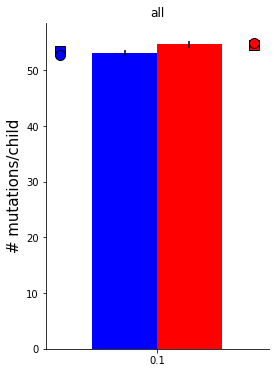

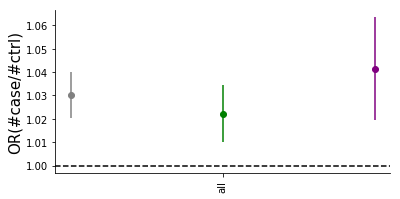

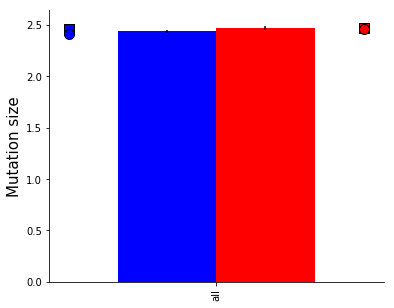

In [24]:
# Overall burden, adjust for father age
PlotBurden(finaldata, [finaldata], ["all"], col=None, freq=1, figprefix="Figure3-All", adjust_patage=True)

num total muts=71822
num total control muts=35409 male=16880 female=18529
num total case muts=36413 male=31894 female=4519
***Test burden - all
1593
Unaff mean=22.227871939736346
Aff mean=22.858129315756436
Mean diff=0.63025737602009
MannwhitneyuResult(statistic=1196716.0, pvalue=0.002705637805446356)
Ttest_relResult(statistic=-3.509661644363018, pvalue=0.0004611708269079333)
Male burden: MannwhitneyuResult(statistic=498193.5, pvalue=0.006865275311493792)
Male burden: Ks_2sampResult(statistic=0.05308995466475781, pvalue=0.05917238409723044)
Female burden: MannwhitneyuResult(statistic=76768.5, pvalue=0.10534087996174946)
Female burden: Ks_2sampResult(statistic=0.08771089663302144, pvalue=0.08141347719762897)
***Odds ratios
all=1.0283543731819595
male=1.030611805256355
female=1.034035174866536
num proband all=1593
num proband male=1397
num proband female=196
num unaff all=1593
num unaff male=762
num unaff female=831
***Test mutation size
MannwhitneyuResult(statistic=642110293.0, pvalue=0

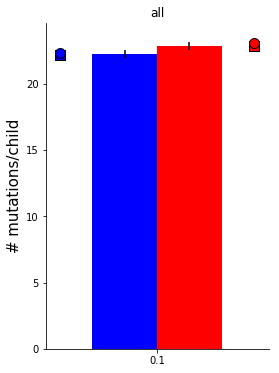

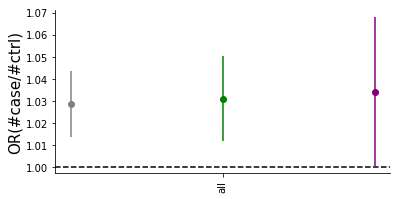

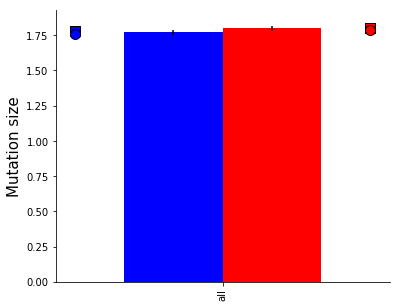

In [25]:
### Overall burden, adjust for father age, no homopolymers
finaldata_nohom = finaldata[finaldata["period_x"]>1]
PlotBurden(finaldata_nohom, [finaldata_nohom], ["all"], col=None, freq=1, figprefix="Figure3-All-NoHomopolymer", adjust_patage=True)

num total muts=171578
num total control muts=84515 male=40724 female=43791
num total case muts=87063 male=76307 female=10756
num total female=54547
num total male=117031
***Test burden - All
1593
Unaff mean=53.05398618957941
Aff mean=54.653483992467045
Mean diff=1.5994978028876332
MannwhitneyuResult(statistic=1175631.0, pvalue=0.00016464408277299932)
Ttest_relResult(statistic=-4.923116524684414, pvalue=9.40181167618077e-07)
Male burden: MannwhitneyuResult(statistic=504043.0, pvalue=0.02072742770336983)
Male burden: Ks_2sampResult(statistic=0.05607253638749702, pvalue=0.042806870966532774)
Female burden: MannwhitneyuResult(statistic=73902.5, pvalue=0.021795513061442066)
Female burden: Ks_2sampResult(statistic=0.08139934674230703, pvalue=0.11479468775706152)
***Odds ratios
all=1.0301484943501154
male=1.0220508790884981
female=1.0413839578442872
num proband all=1593
num proband male=1397
num proband female=196
num unaff all=1593
num unaff male=762
num unaff female=831
***Test mutation siz

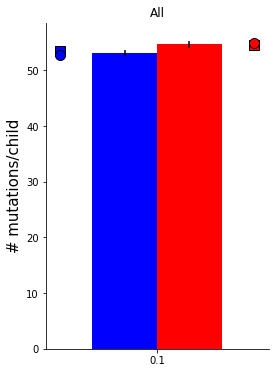

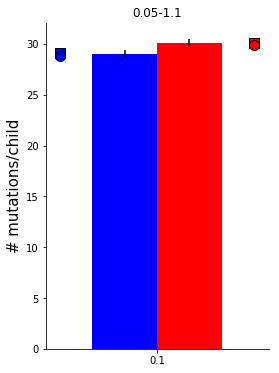

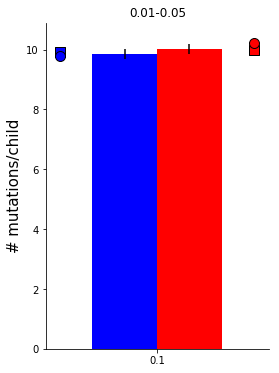

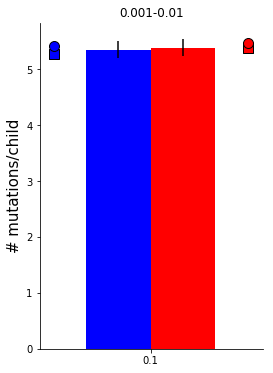

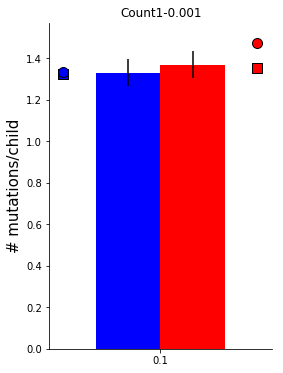

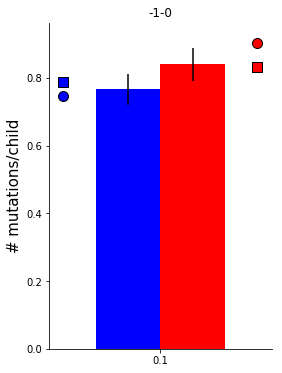

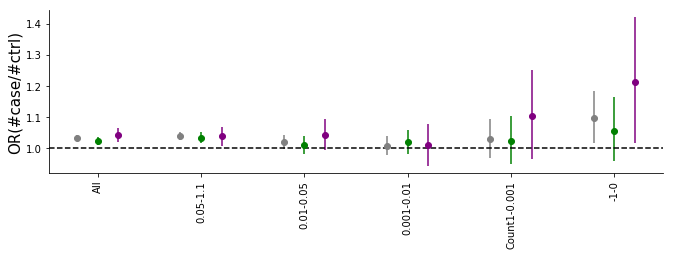

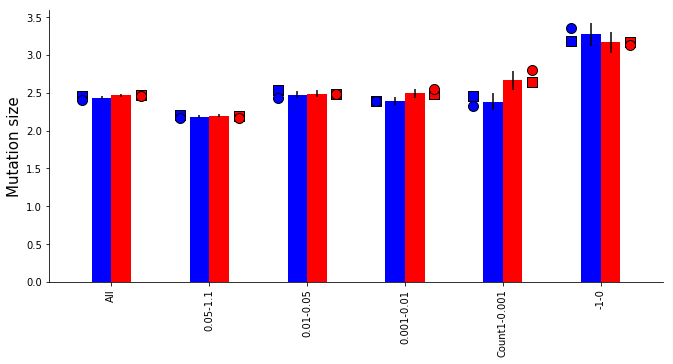

In [48]:
# By freq bin of target allele - overall
# (i.e. <0.001; 0.001-0.01; 0.01-0.05; >0.05)

mintotal = 0.8*max(fdata["total"])

# All
fdata_list = [finaldata]
fdata_labels_list = ["All"]

# Other freq bins
for freqpair in [(0.05, 1.1), (0.01, 0.05), (0.001, 0.01), (-1,0.001), (-1, 0)]:
    minfreq, maxfreq = freqpair
    if minfreq == -1 and maxfreq > 0:
        fdata_list.append(finaldata[(finaldata["total"]>=mintotal) & (finaldata["freq"]>0) & (finaldata["freq"]<=maxfreq)])
        fdata_labels_list.append("Count1-%s"%(maxfreq))
    else:
        fdata_list.append(finaldata[(finaldata["total"]>=mintotal) & (finaldata["freq"]>minfreq) & (finaldata["freq"]<=maxfreq)])
        fdata_labels_list.append("%s-%s"%(minfreq,maxfreq))
PlotBurden(finaldata, fdata_list, fdata_labels_list, col=None, freq=1, figprefix="Figure3-ByFreqBin", adjust_patage=False) 

In [213]:
# Is the OR significantly higher for mutations to "novel" alleles vs. "all"?

table_all = [[1542, 87063-1642],
            [1427, 84515-1526]]
print(scipy.stats.fisher_exact(table_all, alternative="greater"))


# Female significant
table_female = [[206, 10756-212],
            [723, 43791-774]]
print(scipy.stats.fisher_exact(table_female, alternative="greater"))

table_male = [[1336, 76307-1430],
            [704, 40724-752]]
print(scipy.stats.fisher_exact(table_male, alternative="greater"))

(1.0498234774633315, 0.0978557342275829)
(1.1624215301695642, 0.03364859557528735)
(1.0130741689097393, 0.4009557473267617)


num total muts=71822
num total control muts=35409 male=16880 female=18529
num total case muts=36413 male=31894 female=4519
num total female=23048
num total male=48774
***Test burden - All
1593
Unaff mean=22.227871939736346
Aff mean=22.858129315756436
Mean diff=0.63025737602009
MannwhitneyuResult(statistic=1196716.0, pvalue=0.002705637805446356)
Ttest_relResult(statistic=-3.509661644363018, pvalue=0.0004611708269079333)
Male burden: MannwhitneyuResult(statistic=498193.5, pvalue=0.006865275311493792)
Male burden: Ks_2sampResult(statistic=0.05308995466475781, pvalue=0.05917238409723044)
Female burden: MannwhitneyuResult(statistic=76768.5, pvalue=0.10534087996174946)
Female burden: Ks_2sampResult(statistic=0.08771089663302144, pvalue=0.08141347719762897)
***Odds ratios
all=1.0283543731819595
male=1.030611805256355
female=1.034035174866536
num proband all=1593
num proband male=1397
num proband female=196
num unaff all=1593
num unaff male=762
num unaff female=831
***Test mutation size
Mannwh

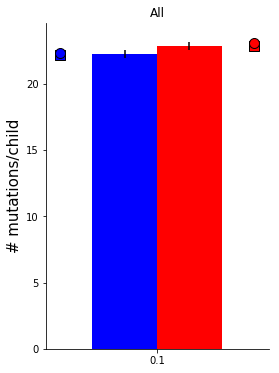

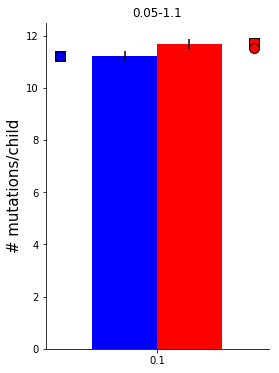

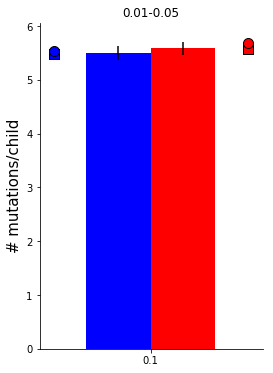

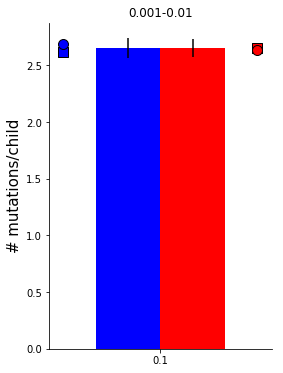

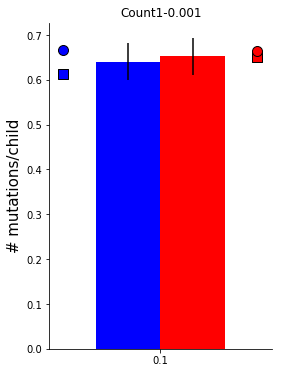

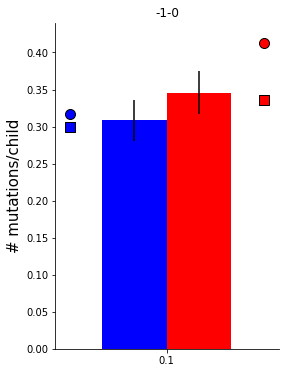

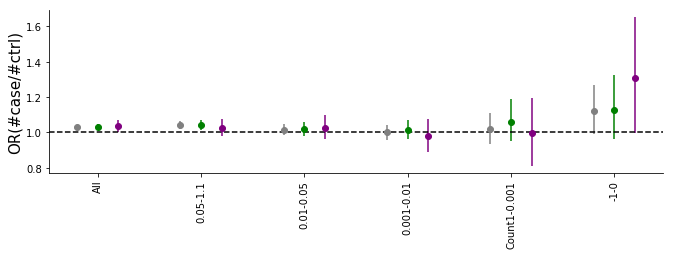

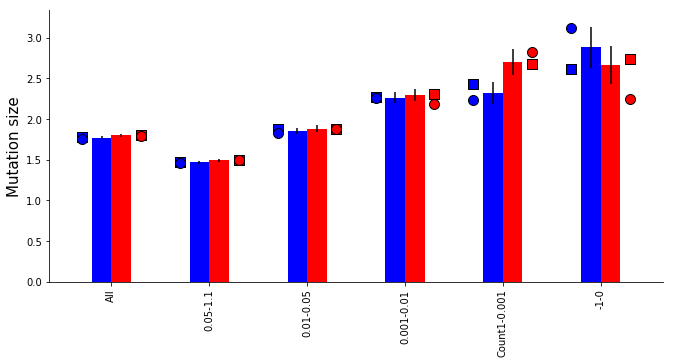

In [49]:
# By freq bin of target allele - overall - no homopolymer
# (i.e. <0.001; 0.001-0.01; 0.01-0.05; >0.05)

mintotal = 0.8*max(fdata["total"])

# All
fdata_list = [finaldata[(finaldata["period_x"]>1)]]
fdata_labels_list = ["All"]

# Other freq bins
for freqpair in [(0.05, 1.1), (0.01, 0.05), (0.001, 0.01), (-1,0.001), (-1, 0)]:
    minfreq, maxfreq = freqpair
    if minfreq == -1 and maxfreq > 0:
        fdata_list.append(finaldata[(finaldata["period_x"]>1) & (finaldata["total"]>=mintotal) & (finaldata["freq"]>0) & (finaldata["freq"]<=maxfreq)])
        fdata_labels_list.append("Count1-%s"%(maxfreq))
    else:
        fdata_list.append(finaldata[(finaldata["period_x"]>1) & (finaldata["total"]>=mintotal) & (finaldata["freq"]>minfreq) & (finaldata["freq"]<=maxfreq)])
        fdata_labels_list.append("%s-%s"%(minfreq,maxfreq))
PlotBurden(finaldata[(finaldata["period_x"]>1)], fdata_list, fdata_labels_list, col=None, freq=1, figprefix="Figure3-ByFreqBin-NoHomopolymer", adjust_patage=False) 

In [28]:
#seldata[(seldata["freq"]==0) & (seldata["LRT_p_value"]<0.05)].sort_values("mut_selection")[["family","chrom","pos","phenotype","freq","period","optimal_ru","newallele","ABC_s_median","mut_selection","LRT_p_value"]]
#seldata["ABC_upper"] = seldata["ABC_s_95%_CI"].apply(lambda x: float(x.split(",")[1].split(")")[0]))
#seldata[seldata["LRT_p_value"]<0.01].head(n=25)

# Selection scores

In [13]:
# Load selection estimates and generate per-allele scores
seldata = pd.read_csv("/storage/BonnieH/selection_project/per_locus/results/per_locus_results_prelim_all_per.txt", sep="\t")
seldata["pos"] = seldata["start"]
seldata = seldata[~np.isnan(seldata["LRT_p_value"])]
seldata["ABC_upper"] = seldata["ABC_s_95%_CI"].apply(lambda x: float(x.split(",")[1].split(")")[0]))
seldata["ABC_lower"] = seldata["ABC_s_95%_CI"].apply(lambda x: float(x.split(",")[0].split("(")[1]))
seldata = pd.merge(finaldata, seldata, on=["chrom","pos"], how="left")

In [16]:
# Set selection score

mintotal = 0.8*max(fdata["total"])

# Want bigger = worse
# Return 0 for unreliable things

def GetSelectionScore(x):
    if np.isnan(x["ABC_s_median"]): return np.nan
    diff = abs(x["newallele"]-x["optimal_ru"])
    s_est = x["ABC_s_median"]
    return diff*s_est

seldata["pscore"] = seldata.apply(GetSelectionScore, 1)

# Locus level s
fdata_list = [seldata]
fdata_labels_list = ["All"]

fdata_list.append(seldata[(seldata["LRT_p_value"]<0.05)])
fdata_labels_list.append("Locus LRTP<0.05")

mintotal = 0.8*max(fdata["total"])

# Get barplots by freq for selected loci
#for freqpair in [(0.05, 1.1), (0.01, 0.05), (0.001, 0.01), (-1,0.001), (-1, 0)]:
#    minfreq, maxfreq = freqpair
#    if minfreq == -1 and maxfreq > 0:
#        fdata_list.append(seldata[(seldata["LRT_p_value"]<0.05) & (seldata["total"]>=mintotal) & (seldata["freq"]>0) & (seldata["freq"]<=maxfreq)])
#        fdata_labels_list.append("Count1-%s"%(maxfreq))
#    else:
#        fdata_list.append(seldata[(seldata["LRT_p_value"]<0.05) & (seldata["total"]>=mintotal) & (seldata["freq"]>minfreq) & (seldata["freq"]<=maxfreq)])
#        fdata_labels_list.append("%s-%s"%(minfreq,maxfreq))
       
#PlotBurden(seldata, fdata_list, fdata_labels_list, col=None, maxORy=3, freq=1,
#           figprefix="Figure4-selection-byfreq", adjust_patage=False) 

171578
108222
36832
19182
4630
2712
901
294
348
189
51
19
171578
108222
36832
19182
4630
2712
901
294
348
189
51
19
171578
145054
26524
2712
38188
31404
6784
436
3143
2051
1092
113
857
517
340
27


IndexError: list index out of range

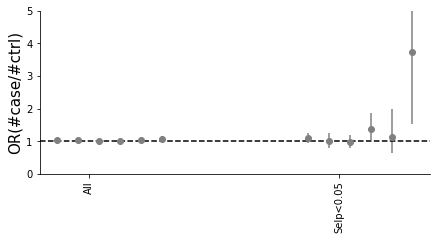

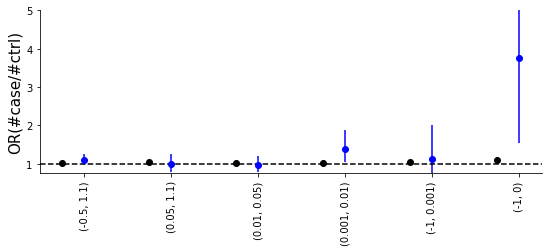

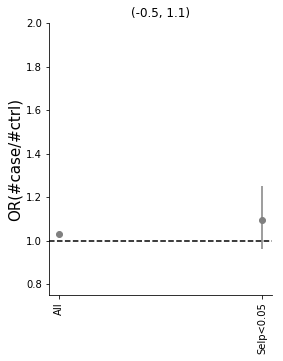

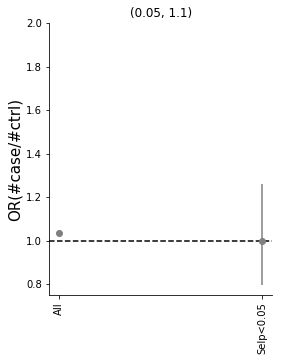

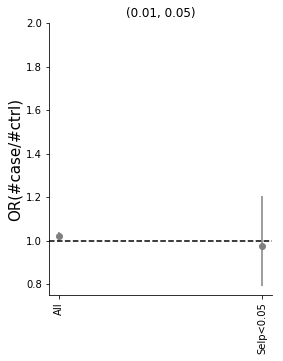

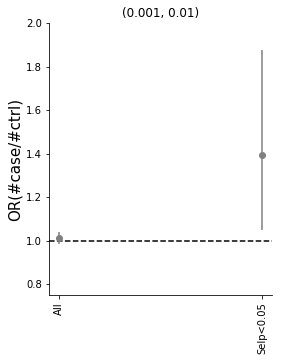

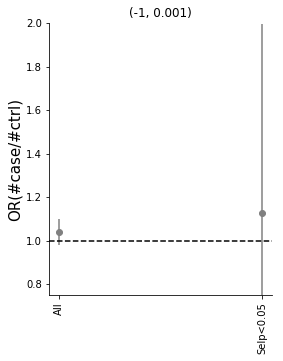

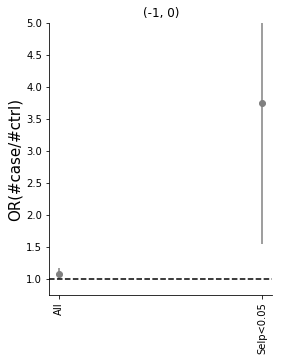

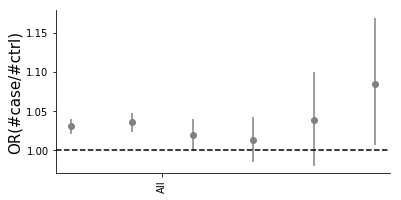

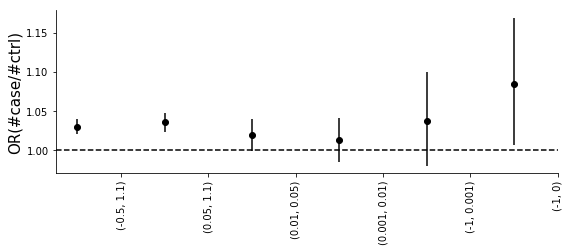

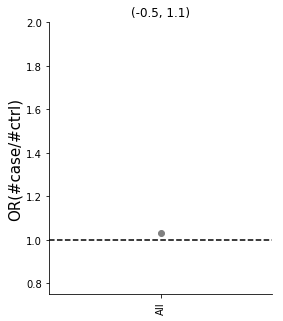

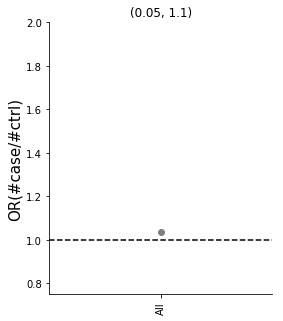

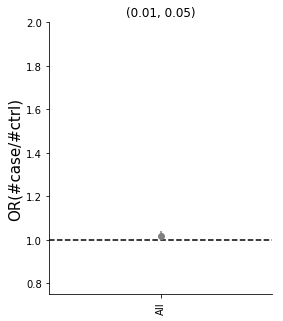

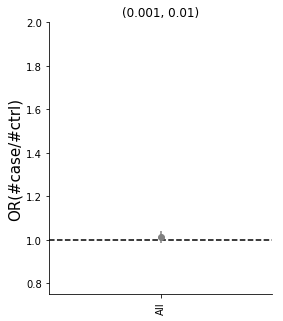

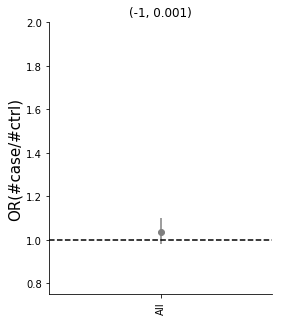

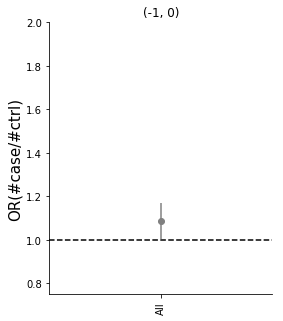

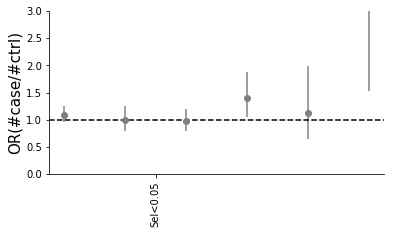

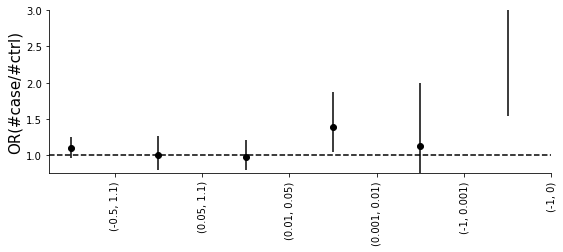

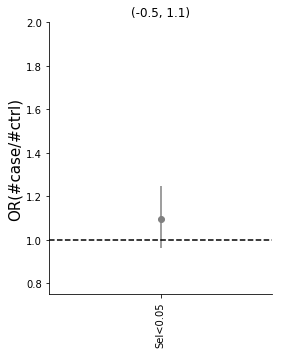

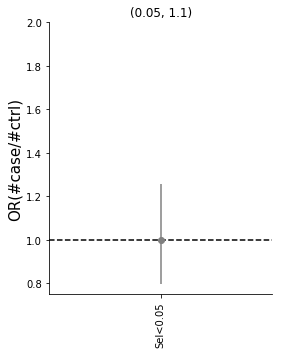

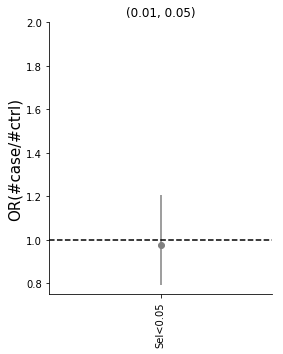

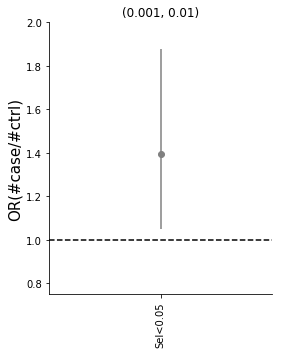

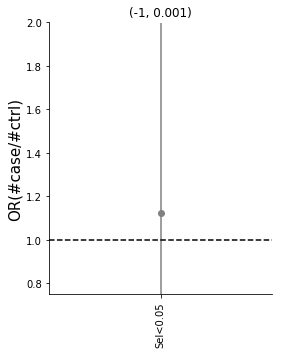

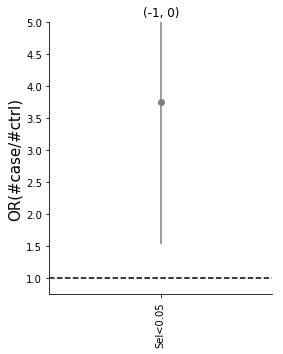

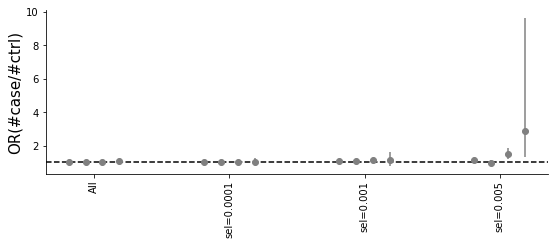

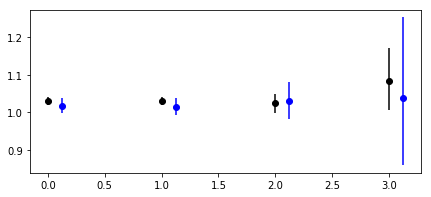

In [42]:
       
def PlotBurdenByAF(full_fdata, fdata_list,fdata_list_labels, maxORy=None, figprefix=None, freqbins=[]):
    fdata = full_fdata
    
    # Get list of families to use
    families = set(fdata["family"])
    
    num_unaff = len(families)
    num_aff = len(families)
    
    odds_ratios = [] # list of lists
    odds_ratios_high = []
    odds_ratios_low = []
        
    for i in range(len(fdata_list)):
        fdata = fdata_list[i]
        flabel = fdata_list_labels[i]
        odds_rat_cat = []
        odds_high_cat = []
        odds_low_cat = []
        for freqpair in freqbins:
            minfreq,maxfreq = freqpair
            if maxfreq>0 and minfreq==-1:
                usedata = fdata[(fdata["count"]>0) & (fdata["freq"]<=maxfreq)] # restrict by freq soon
            else:
                usedata = fdata[(fdata["freq"]>minfreq) & (fdata["freq"]<=maxfreq)] # restrict by freq soon
            print(usedata.shape[0])
            
            child_counts = usedata.groupby(["child","phenotype","family","father_age_birth_years"], as_index=False).agg({"posterior": len})
            child_counts.columns = ["child","phenotype","family","father_age_birth_years","nummut"]
            child_counts_by_sex = usedata.groupby(["child","phenotype","family","sex"], as_index=False).agg({"posterior": len})
            child_counts_by_sex.columns = ["child","phenotype","family","sex","nummut"]

            aff_counts = GetCounts(child_counts, 2, families)
            unaff_counts = GetCounts(child_counts, 1, families)
            
            total_mut = np.sum(aff_counts)+np.sum(unaff_counts)
            perc_aff = np.sum(aff_counts)/(np.sum(aff_counts)+np.sum(unaff_counts))
            
            OR_all = num_unaff*1.0/num_aff*perc_aff/(1-perc_aff)

            # Compute stderrs on p total_mut_all_list, perc_mut_aff_all_list
            perc_se_all = np.sqrt(perc_aff*(1-perc_aff)/total_mut)
            perc_low = perc_aff-1.96*perc_se_all
            perc_high = perc_aff+1.96*perc_se_all
            if perc_low<0: perc_low = 0
            if perc_low>1: perc_high=1
            OR_high_all = num_unaff*1.0/num_aff*perc_high/(1-perc_high)
            OR_low_all = num_unaff*1.0/num_aff*perc_low/(1-perc_low)
            
            if usedata.shape[0] < 0: # TODO replace with threshold if we want
                odds_rat_cat.append(np.nan)
                odds_high_cat.append(np.nan)
                odds_low_cat.append(np.nan)
            else:
                odds_rat_cat.append(OR_all)
                odds_high_cat.append(OR_high_all)
                odds_low_cat.append(OR_low_all)

        odds_ratios.append(odds_rat_cat)
        odds_ratios_high.append(odds_high_cat)
        odds_ratios_low.append(odds_low_cat)
    
    #### Plot 1: all separate group per annotation, separate by allele freq within 
    xvals = range(len(fdata_list))
    fig = plt.figure()
    fig.set_size_inches((5+len(fdata_list), 3))
    ax = fig.add_subplot(111)
    W2 = 0.5/len(freqbins)
    for j in range(len(freqbins)):
        OR_all = [item[j] for item in odds_ratios]
        OR_high_all = [item[j] for item in odds_ratios_high]
        OR_low_all = [item[j] for item in odds_ratios_low]
        ax.errorbar([item+W2*j for item in xvals], OR_all,
                    yerr=[[(OR_all[i])-(OR_low_all[i]) for i in range(len(OR_all))],
                          [(OR_high_all[i])-(OR_all[i]) for i in range(len(OR_all))]],
                    color="gray", fmt="o")
    if maxORy is not None:
        ax.set_ylim(bottom=0, top=maxORy)
    ax.axhline(y=1, linestyle="dashed", color="black")
    ax.set_xticks([item+W2*1.5 for item in xvals])
    ax.set_xticklabels(fdata_list_labels, rotation=90)
    ax.set_ylabel("OR(#case/#ctrl)", size=15)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom');
    if figprefix is not None:
        fig.savefig(os.path.join(OUTDIR, figprefix+"-OR-byAF.pdf"))
        

    #### Plot 2: separate groups per freq bin, separate by annotation within
    xvals = range(len(freqbins))
    fig = plt.figure()
    fig.set_size_inches((3+len(freqbins), 3))
    ax = fig.add_subplot(111)
    W2 = 0.5/len(fdata_list)
    colors = ["black","blue"]
    for j in range(len(fdata_list)):
        OR_all = odds_ratios[j]
        OR_high_all = odds_ratios_high[j]
        OR_low_all = odds_ratios_low[j]
        ax.errorbar([item+W2*j for item in xvals], OR_all,
                    yerr=[[(OR_all[i])-(OR_low_all[i]) for i in range(len(OR_all))],
                          [(OR_high_all[i])-(OR_all[i]) for i in range(len(OR_all))]],
                    color=colors[j], fmt="o")
    if maxORy is not None:
        ax.set_ylim(bottom=0.75, top=maxORy)
    #ax.set_ylim(bottom=0.75, top=2)
    ax.axhline(y=1, linestyle="dashed", color="black")
    ax.set_xticks([item+W2 for item in xvals])
    ax.set_xticklabels(freqbins, rotation=90)
    ax.set_ylabel("OR(#case/#ctrl)", size=15)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom');
    if figprefix is not None:
        fig.savefig(os.path.join(OUTDIR, figprefix+"-OR-bycatAF.pdf"))
    

    #### Plot 3: Separate plot per freq bin
    for j in range(len(freqbins)):
        fig = plt.figure()
        fig.set_size_inches((4, 5))
        ax = fig.add_subplot(111)
        OR_all = [item[j] for item in odds_ratios]
        OR_high_all = [item[j] for item in odds_ratios_high]
        OR_low_all = [item[j] for item in odds_ratios_low]
        ax.errorbar(range(len(fdata_list)), OR_all, 
                   yerr=[[(OR_all[i])-(OR_low_all[i]) for i in range(len(OR_all))],
                          [(OR_high_all[i])-(OR_all[i]) for i in range(len(OR_all))]],
                    color="gray", fmt="o")
        ax.axhline(y=1, linestyle="dashed", color="black")
        ax.set_xticks(range(len(fdata_list)))
        ax.set_xticklabels(fdata_labels_list, rotation=90)
        ax.set_ylabel("OR(#case/#ctrl)", size=15)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom');
        ax.set_title(freqbins[j])
        if max(OR_high_all)>3:
            ax.set_ylim(bottom=0.75, top=5)
        else:
            ax.set_ylim(bottom=0.75, top=2)
        if figprefix is not None:
            fig.savefig(os.path.join(OUTDIR, figprefix+"-OR-byAF-%s.pdf"%(str(freqbins[j]))))
mintotal = 0.8*max(fdata["total"])


#### Plot by selection locus score within each freq bin ####
fdata_list = [seldata, seldata[(seldata["LRT_p_value"]<0.05) & ~np.isnan(seldata["LRT_p_value"])]]
fdata_labels_list = ["All","Selp<0.05"]
PlotBurdenByAF(seldata, fdata_list, fdata_labels_list, figprefix="Figure4-all-locus-both",maxORy=5,
               freqbins=[(-0.5,1.1), (0.05, 1.1), (0.01, 0.05), (0.001, 0.01), (-1,0.001), (-1, 0)])


fdata_list = [seldata]
fdata_labels_list = ["All"]
PlotBurdenByAF(seldata, fdata_list, fdata_labels_list, figprefix="Figure4-all-locus",
               freqbins=[(-0.5,1.1), (0.05, 1.1), (0.01, 0.05), (0.001, 0.01), (-1,0.001), (-1, 0)])

fdata_list = [seldata[(seldata["LRT_p_value"]<0.05) & ~np.isnan(seldata["LRT_p_value"])]]
fdata_labels_list = ["Sel<0.05"]
PlotBurdenByAF(seldata, fdata_list, fdata_labels_list, figprefix="Figure4-sel-locus",maxORy=3,
               freqbins=[(-0.5,1.1), (0.05, 1.1), (0.01, 0.05), (0.001, 0.01), (-1,0.001), (-1, 0)])


#### Plot by selection allele score within each freq bin ####
fdata_list = [seldata]
fdata_labels_list = ["All"]

for sthresh in [10e-5, 10e-4, 5e-3]:
    fdata_list.append(seldata[(seldata["pscore"]>=sthresh) & (seldata["total"]>=mintotal)
                         ])
    fdata_labels_list.append("sel=%s"%sthresh)
PlotBurdenByAF(seldata, fdata_list, fdata_labels_list, figprefix="Figure4-selection-allele",
               freqbins=[(-0.5, 1.1), (0.01, 1.1), (-0.5,0.01),(-1,0)])



In [316]:
# List of top scoring
cols = ["phenotype","chrom","pos","mutsize","motif","freq","pscore","TSS_GENE","LRT_p_value"]
seldata[(seldata["pscore"]>0.005) & (seldata["freq"]<=0)].sort_values(["phenotype","pscore"])[cols]

,phenotype,chrom,pos,mutsize,motif,freq,pscore,TSS_GENE,LRT_p_value
47869,1,19,7724473,-3,AC,0.0,0.00528,CLEC4G,0.049935
5765,1,4,30716894,1,AGC,0.0,0.00672,PCDH7,0.784834
5163,1,5,5725645,-4,AC,0.0,0.00788,AC026736.1,0.029963
58660,1,3,47997708,-3,AAAG,0.0,0.00861,MAP4,0.038560
2325,1,3,139114125,-4,AC,0.0,0.01180,MRPS22,0.079717
187,1,11,48001350,5,AC,0.0,0.01350,PTPRJ-AS1,0.099331
29145,1,17,2057111,3,CCG,0.0,0.03378,HIC1,0.108880
3722,2,7,68421891,4,AAAT,0.0,0.00504,AC093655.1,1.000000
23246,2,5,24946660,-3,AC,0.0,0.00540,RF00019,0.085941
51564,2,17,55529610,-6,AC,0.0,0.00690,SMIM36,0.080632


num total muts=59619
num total control muts=29437 male=14021 female=15416
num total case muts=30182 male=26407 female=3775
num total female=19191
num total male=40428
***Test burden - All
1593
Unaff mean=18.478970495919647
Aff mean=18.94664155681105
Mean diff=0.4676710608914014
MannwhitneyuResult(statistic=1205272.5, pvalue=0.007096098465689082)
Ttest_relResult(statistic=-2.9122975204743566, pvalue=0.003637793653968975)
Male burden: MannwhitneyuResult(statistic=504922.5, pvalue=0.023952881289366144)
Male burden: Ks_2sampResult(statistic=0.047482701026008114, pvalue=0.10371223539777127)
Female burden: MannwhitneyuResult(statistic=75326.5, pvalue=0.05060780889766431)
Female burden: Ks_2sampResult(statistic=0.07692968884304624, pvalue=0.1442361245352316)
***Odds ratios
all=1.0253082854910487
male=1.0273032010425918
female=1.0382219506899804
num proband all=1593
num proband male=1397
num proband female=196
num unaff all=1593
num unaff male=762
num unaff female=831
***Test mutation size
Man

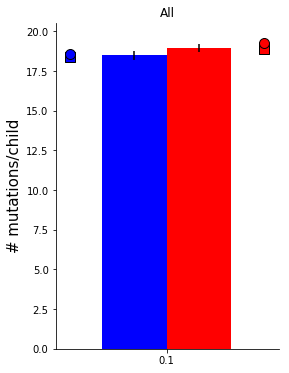

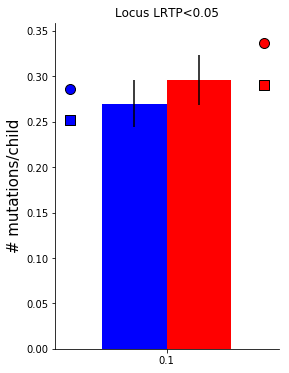

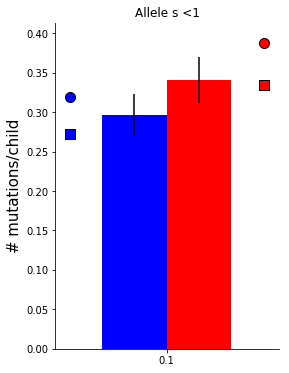

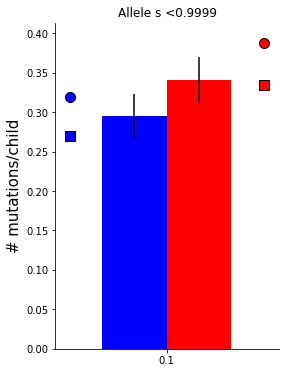

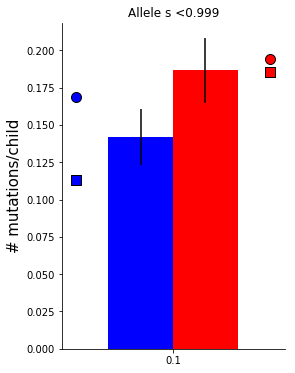

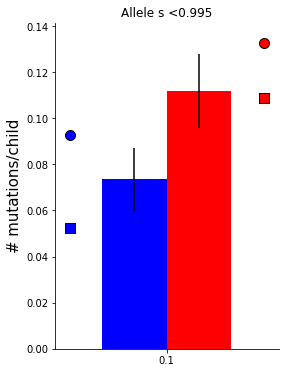

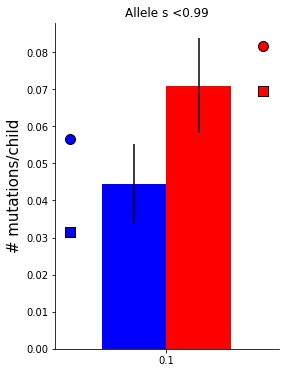

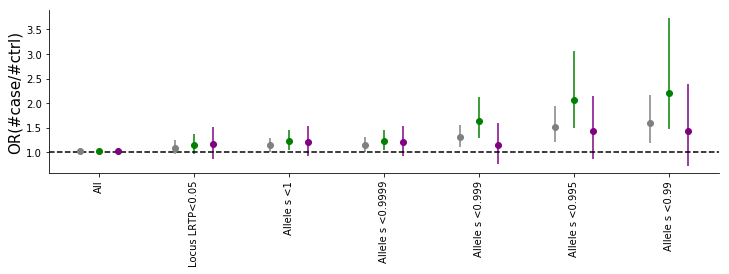

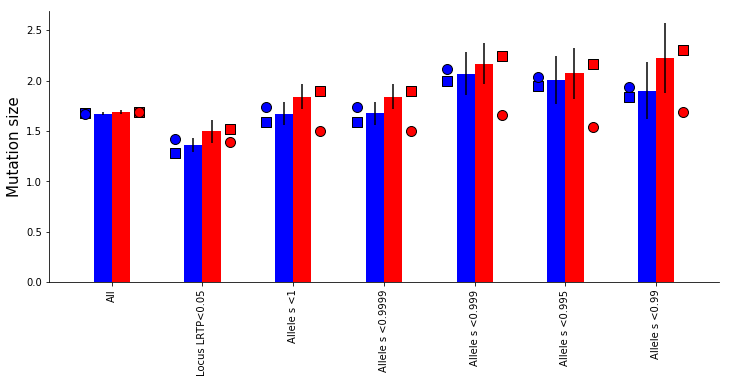

In [87]:
# Try to add Bonnie's scores
#selscores = pd.read_csv("/storage/BonnieH/selection_project/per_locus/results/per_locus_results_prelim.txt", sep="\t")
selscores = pd.read_csv("/storage/BonnieH/selection_project/per_locus/results/per_locus_results_prelim_all_per.txt", sep="\t")
selscores["pos"] = selscores["start"]
seldata = pd.merge(finaldata, selscores, on=["chrom","pos"])
seldata = seldata[~np.isnan(seldata["LRT_p_value"])]
seldata["mut_selection"] = seldata.apply(lambda x: 1-x["ABC_s_median"]*abs(x["optimal_ru"]-x["newallele"]), 1)
seldata["ABC_upper"] = seldata["ABC_s_95%_CI"].apply(lambda x: float(x.split(",")[1].split(")")[0]))

# Locus level s
fdata_list = [seldata]
fdata_labels_list = ["All"]

fdata_list.append(seldata[(seldata["LRT_p_value"]<0.05)])
fdata_labels_list.append("Locus LRTP<0.05")

for sthresh in [1, 0.9999, 0.999, 0.995, 0.99]:
    fdata_list.append(seldata[(seldata["ABC_upper"]>0.005) & (seldata["LRT_p_value"]<1) & (seldata["mut_selection"]<sthresh) &(seldata["freq"]<0.01)])
    fdata_labels_list.append("Allele s <%s"%sthresh)

PlotBurden(seldata, fdata_list, fdata_labels_list, col=None, freq=1, figprefix="del-selection", adjust_patage=False) 

# Figure 3C,D, Supp Fig. 10 Mutation burden by category

num total muts=171578
num total control muts=84515 male=40724 female=43791
num total case muts=87063 male=76307 female=10756
num total female=54547
num total male=117031
***Test burden - all
1593
Unaff mean=53.05398618957941
Aff mean=54.653483992467045
Mean diff=1.5994978028876332
MannwhitneyuResult(statistic=1175631.0, pvalue=0.00016464408277299932)
Ttest_relResult(statistic=-4.923116524684414, pvalue=9.40181167618077e-07)
Male burden: MannwhitneyuResult(statistic=504043.0, pvalue=0.02072742770336983)
Male burden: Ks_2sampResult(statistic=0.05607253638749702, pvalue=0.042806870966532774)
Female burden: MannwhitneyuResult(statistic=73902.5, pvalue=0.021795513061442066)
Female burden: Ks_2sampResult(statistic=0.08139934674230703, pvalue=0.11479468775706152)
***Odds ratios
all=1.0301484943501154
male=1.0220508790884981
female=1.0413839578442872
num proband all=1593
num proband male=1397
num proband female=196
num unaff all=1593
num unaff male=762
num unaff female=831
***Test mutation siz

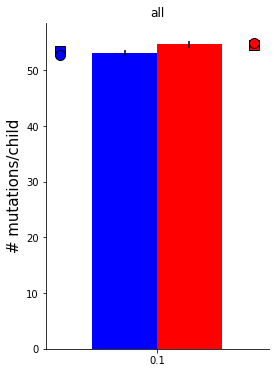

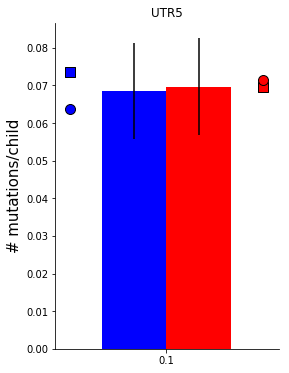

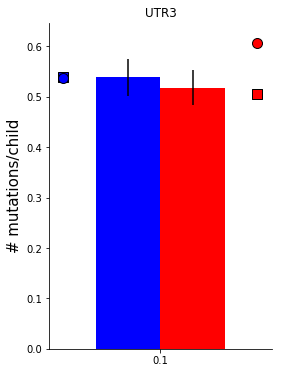

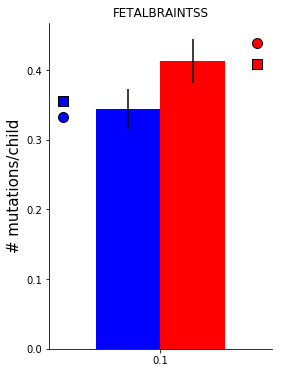

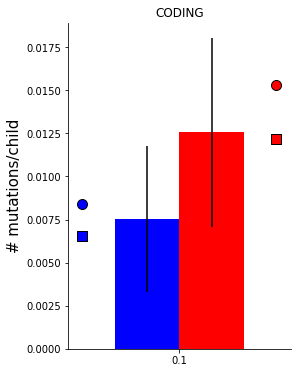

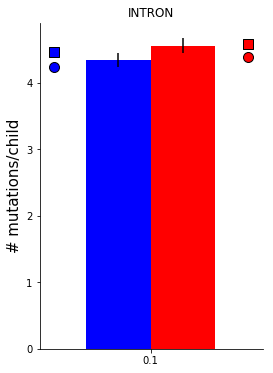

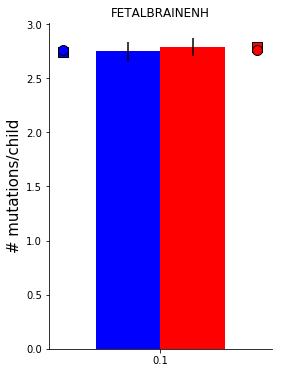

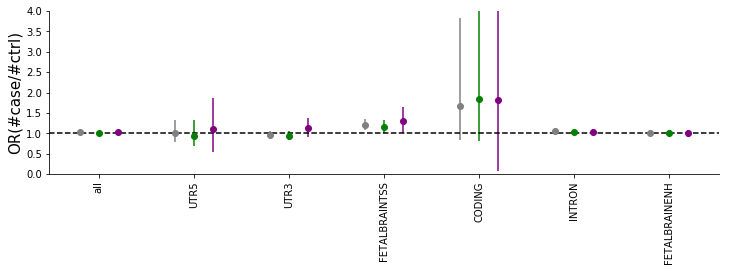

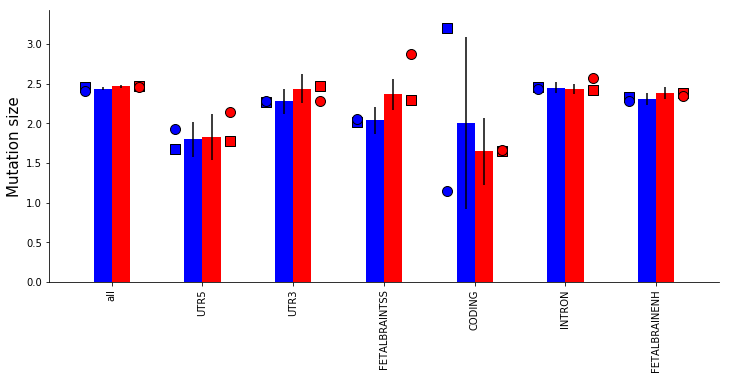

In [44]:
mintotal = 0
# By category
fdata_list = [finaldata[(finaldata["total"]>=mintotal)]]
fdata_labels_list = ["all"]
for col in ['FEATURE-UTR5','FEATURE-UTR3', 'FEATURE-FETALBRAINTSS', 'FEATURE-CODING', 'FEATURE-INTRON', 'FEATURE-FETALBRAINENH']:
    fdata_list.append(finaldata[(finaldata[col]>0) & (finaldata["total"]>=mintotal)])
    fdata_labels_list.append(col.split("-")[1])

PlotBurden(finaldata, fdata_list, fdata_labels_list, col=None, freq=1, maxORy=4, figprefix="Figure3-ByFeature1-all", adjust_patage=False) 

num total muts=71822
num total control muts=35409 male=16880 female=18529
num total case muts=36413 male=31894 female=4519
num total female=23048
num total male=48774
***Test burden - all
1593
Unaff mean=22.227871939736346
Aff mean=22.858129315756436
Mean diff=0.63025737602009
MannwhitneyuResult(statistic=1196716.0, pvalue=0.002705637805446356)
Ttest_relResult(statistic=-3.509661644363018, pvalue=0.0004611708269079333)
Male burden: MannwhitneyuResult(statistic=498193.5, pvalue=0.006865275311493792)
Male burden: Ks_2sampResult(statistic=0.05308995466475781, pvalue=0.05917238409723044)
Female burden: MannwhitneyuResult(statistic=76768.5, pvalue=0.10534087996174946)
Female burden: Ks_2sampResult(statistic=0.08771089663302144, pvalue=0.08141347719762897)
***Odds ratios
all=1.0283543731819595
male=1.030611805256355
female=1.034035174866536
num proband all=1593
num proband male=1397
num proband female=196
num unaff all=1593
num unaff male=762
num unaff female=831
***Test mutation size
Mannwh

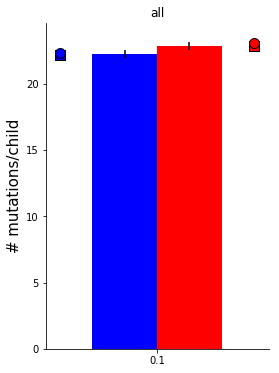

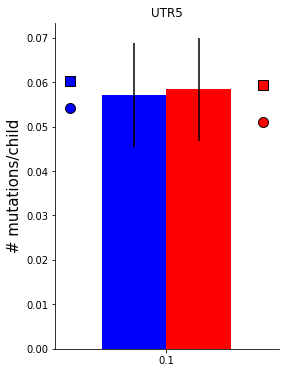

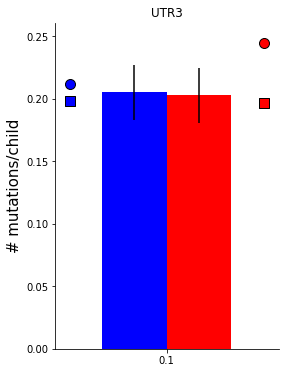

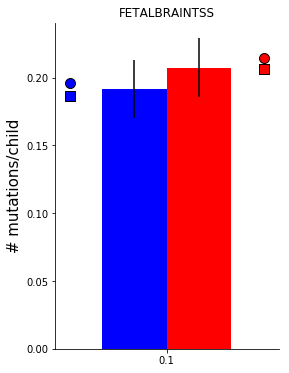

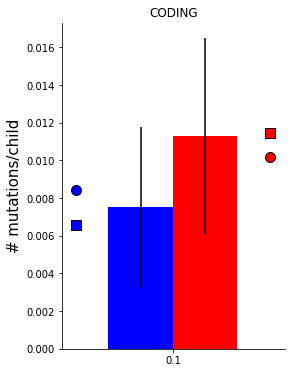

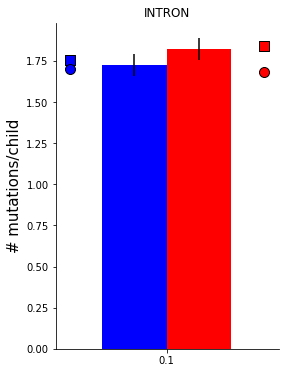

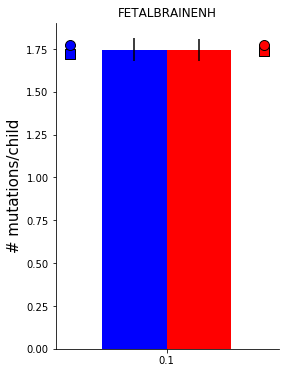

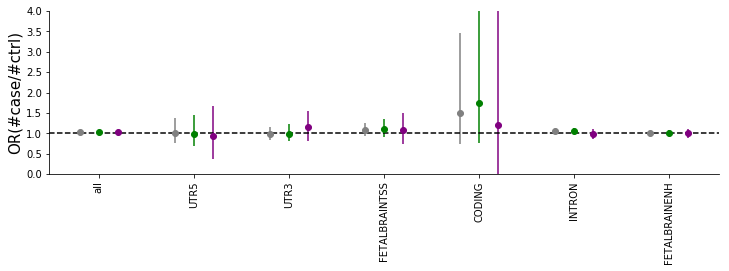

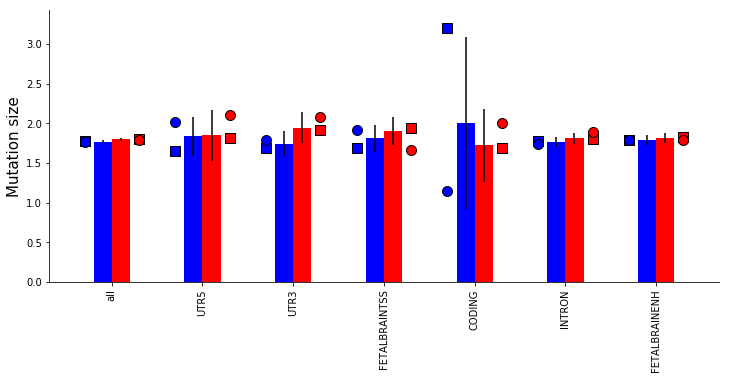

In [45]:
mintotal = 0

# By category - nohomopolymer
fdata_list = [finaldata[(finaldata["period_x"]>1) & (finaldata["total"]>=mintotal) ]]
fdata_labels_list = ["all"]
for col in ['FEATURE-UTR5','FEATURE-UTR3', 'FEATURE-FETALBRAINTSS', 'FEATURE-CODING', 'FEATURE-INTRON', 'FEATURE-FETALBRAINENH']:
    fdata_list.append(finaldata[(finaldata[col]>0) & (finaldata["period_x"]>1) & (finaldata["total"]>=mintotal) ])
    fdata_labels_list.append(col.split("-")[1])
PlotBurden(finaldata, fdata_list, fdata_labels_list, maxORy=4, col=None, freq=1, figprefix="Figure3-ByFeature1-all-nohomopolymer", adjust_patage=False) 

# Supplementary Fig. 11

974004
648925


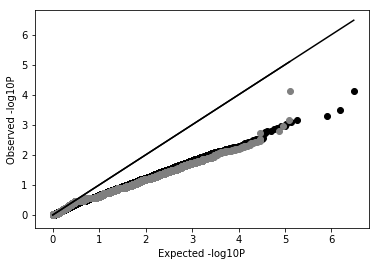

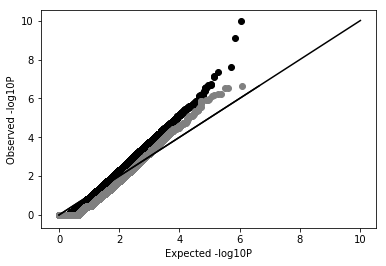

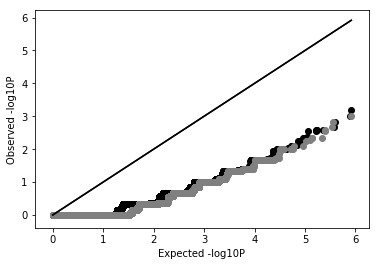

In [127]:
# Load per-locus mutation info. Annotate with period
data = pd.read_csv(LOCFILE, delim_whitespace=True)
data = pd.merge(data, annot[["chrom","pos","period"]], how="left", on=["chrom","pos"])

print(data.shape[0])
print(data[data["period"]>1].shape[0])

def QQPlot(pvals, ax, color="black"):
    y_pvals = -1*np.log10(sorted(pvals))
    x_pvals = -1*np.log10(sorted(list(np.random.uniform(size=len(pvals)))))
    ax.scatter(x_pvals, y_pvals, color=color)
    maxval = max(max(y_pvals), max(x_pvals))
    ax.plot([0,maxval],[0,maxval], color="black")
    
fig = plt.figure()
ax = fig.add_subplot(111)
QQPlot(list(data[~np.isnan(data["assoc_p"])]["assoc_p"]), ax, color="black")
QQPlot(list(data[(~np.isnan(data["assoc_p"])) & (data["period"]>1)]["assoc_p"]), ax, color="gray")
ax.set_xlabel("Expected -log10P")
ax.set_ylabel("Observed -log10P")
fig.savefig(os.path.join(OUTDIR, "SuppFig_QQPlot_assoc_P.png"))

fig = plt.figure()
ax = fig.add_subplot(111)
QQPlot(list(data[~np.isnan(data["tdt_p_combined"])]["tdt_p_combined"]), ax, color="black")
QQPlot(list(data[(~np.isnan(data["tdt_p_combined"])) & (data["period"]>1)]["tdt_p_combined"]), ax, color="gray")
ax.set_xlabel("Expected -log10P")
ax.set_ylabel("Observed -log10P")
fig.savefig(os.path.join(OUTDIR, "SuppFig_QQPlot_tdt_P.png"))

fig = plt.figure()
ax = fig.add_subplot(111)
QQPlot(list(data[~np.isnan(data["fisher_p"])]["fisher_p"]), ax, color="black")
QQPlot(list(data[(~np.isnan(data["fisher_p"])) & (data["period"]>1)]["fisher_p"]), ax, color="gray")
ax.set_xlabel("Expected -log10P")
ax.set_ylabel("Observed -log10P")
fig.savefig(os.path.join(OUTDIR, "SuppFig_QQPlot_burden_P.png"))

# Supplementary Fig. 12: Power

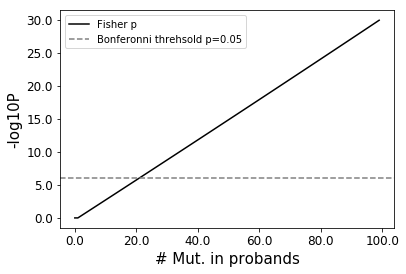

In [10]:
# Contingency tables will have: status(0/1) x mutation(0/1)
# First, for different numbers of families, see how many mutations
# we need to see in probands (with 0 in controls) for genome-wide significance

NUMLOCI = 60000 # 900000 # approximate num genome-wide loci analyzed per family.
# should we use total number, of only total num with any mutations?
NUMMUTS = range(100)
NVALS = [2500]
power_vals = {} # N -> vals

for N in NVALS:
    # For each N, test different numbers of muts in proband
    pvals = []
    for aff_mut in NUMMUTS:
        table = [[aff_mut, 0], [N-aff_mut, N]]
        p = scipy.stats.fisher_exact(table)[1]
        pvals.append(p)
    power_vals[N] = pvals

fig = plt.figure()
ax = fig.add_subplot(111)
N = 2500
ax.plot(NUMMUTS, [-1*np.log10(item) for item in power_vals[N]], label="Fisher p", color="black")
ax.axhline(y=-1*np.log10(0.05/NUMLOCI), color="gray", linestyle="dashed", label="Bonferonni threhsold p=0.05")
ax.set_xlabel("# Mut. in probands", size=15)
ax.set_ylabel("-log10P", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12);
ax.legend()
fig.savefig(os.path.join(OUTDIR, "SuppFigure_Power.pdf"))

In [31]:
!pwd

/storage/mgymrek/workspace/ssc-denovos-paper/figure-notebooks
